# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Graphlab Create

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [3]:
sales = graphlab.SFrame('../data/kc_house_data.gl/')

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [4]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

Less than 8 successfully started. Using only 7 workers.

All operations will proceed as normal, but lambda operations will not be able to use all available cores.

(The location of the log file is printed at the start of the GraphLab server).

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in GraphLab Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = graphlab.linear_regression.create(sales, target='price', features=all_features,
                                              validation_set=None, 
                                              l2_penalty=0., l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

+-----------+----------+-----------+--------------+--------------------+---------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+-----------+--------------+--------------------+---------------+

Tuning step size. First iteration could take longer than subsequent iterations.

| 1         | 2        | 0.000002  | 1.145234     | 6962915.603493     | 426631.749026 |

| 2         | 3        | 0.000002  | 1.163878     | 6843144.200219     | 392488.929838 |

| 3         | 4        | 0.000002  | 1.182262     | 6831900.032123     | 385340.166783 |

| 4         | 5        | 0.000002  | 1.201312     | 6847166.848958     | 384842.383767 |

| 5         | 6        | 0.000002  | 1.220362     | 6869667.895833     | 385998.458623 |

| 6         | 7        | 0.000002  | 1.233397     | 6847177.773672     | 380824.455891 |

+-----------+----------+-----------+--------------+--------------------+---------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [7]:
model_all.get('coefficients')

name,index,value,stderr
(intercept),None,274873.05595,None
bedrooms,None,0.0,None
bedrooms_square,None,0.0,None
bathrooms,None,8468.53108691,None
sqft_living,None,24.4207209824,None
sqft_living_sqrt,None,350.060553386,None
sqft_lot,None,0.0,None
sqft_lot_sqrt,None,0.0,None
floors,None,0.0,None
floors_square,None,0.0,None


Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [8]:
(training_and_validation, testing) = sales.random_split(.9,seed=1) # initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed=1) # split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# def k_fold_cross_validation(k, l1_penalty, data, output_name, features_list):
#     n = len(data)
#     validation_error=[]
#     for i in xrange(k):
#         start = (n*i)/k
#         end = (n*(i+1))/k-1
#         validation = data[start:end+1]
#         train = data[:start].append(data[end+1:])
#         model = graphlab.linear_regression.create(train, target = output_name, features = features_list,l1_penalty=l1_penalty, l2_penalty=0,
#                                                   validation_set = None, verbose=False)
#         error = ((validation[output_name]-model.predict(validation))**2).sum()
#         validation_error.append(error)
#     return np.mean(validation_error)

[  1.00000000e+01   3.16227766e+01   1.00000000e+02   3.16227766e+02
   1.00000000e+03   3.16227766e+03   1.00000000e+04   3.16227766e+04
   1.00000000e+05   3.16227766e+05   1.00000000e+06   3.16227766e+06
   1.00000000e+07]
Min validation error is: 6.25766285142e+14 in index: 0


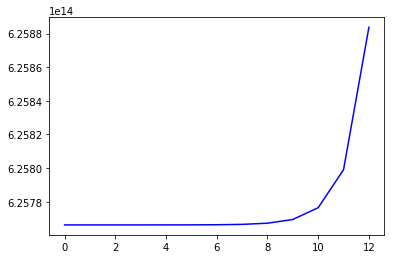

In [37]:
# data = polynomial_sframe(training['sqft_living'],15)
# features_list = data.column_names()
# data['price'] = train_valid_shuffled['price']
# k = 10 
# output_name = 'price'
validation_error = []
l1_penalties = np.logspace(1, 7, num=13)
print l1_penalties
for l1_penalty in l1_penalties:
    model = graphlab.linear_regression.create(training, target='price', features=all_features, l1_penalty=l1_penalty,
                                              l2_penalty=0, validation_set=None, verbose=False)
    RSS = ((model.predict(validation) - validation['price'])**2).sum()
    validation_error.append(RSS)
plt.plot(validation_error,'b-')
index = validation_error.index(min(validation_error))
print 'Min validation error is:',validation_error[index],'in index:',index

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [36]:
model = graphlab.linear_regression.create(training, target='price', features=all_features, l1_penalty=1e1, validation_set=None, verbose=False)
model.get('coefficients').print_rows(num_rows=18)

+------------------+-------+------------------+--------+
|       name       | index |      value       | stderr |
+------------------+-------+------------------+--------+
|   (intercept)    |  None |  18993.4795138   |  None  |
|     bedrooms     |  None |  7936.96861251   |  None  |
| bedrooms_square  |  None |  936.993723341   |  None  |
|    bathrooms     |  None |  25409.5830315   |  None  |
|   sqft_living    |  None |   39.115122565   |  None  |
| sqft_living_sqrt |  None |  1124.64999347   |  None  |
|     sqft_lot     |  None | 0.00348381659616 |  None  |
|  sqft_lot_sqrt   |  None |  148.258443122   |  None  |
|      floors      |  None |  21204.3350605   |  None  |
|  floors_square   |  None |  12915.5225533   |  None  |
|    waterfront    |  None |  601905.329341   |  None  |
|       view       |  None |   93312.819553   |  None  |
|    condition     |  None |  6609.03701533   |  None  |
|      grade       |  None |  6206.93883858   |  None  |
|    sqft_above    |  None |  4

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

**None**

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [38]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [40]:
l1_penalty_values = np.logspace(8, 10, num=20)
print l1_penalty_values

[  1.00000000e+08   1.27427499e+08   1.62377674e+08   2.06913808e+08
   2.63665090e+08   3.35981829e+08   4.28133240e+08   5.45559478e+08
   6.95192796e+08   8.85866790e+08   1.12883789e+09   1.43844989e+09
   1.83298071e+09   2.33572147e+09   2.97635144e+09   3.79269019e+09
   4.83293024e+09   6.15848211e+09   7.84759970e+09   1.00000000e+10]


Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model['coefficients']['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [44]:
sparsities = []
for l1_penalty in np.logspace(8,10,num=20):
    model = graphlab.linear_regression.create(training, target='price', features=all_features, l1_penalty=l1_penalty, l2_penalty=0,
                                             validation_set=None, verbose=False)
    sparsities.append(model['coefficients']['value'].nnz())
print 'Number of non-zero weights as l1_penalty increase:',sparsities

Number of non-zero weights as l1_penalty increase: [18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 15, 15, 13, 12, 10, 6, 5, 3, 1, 1]


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [ ]:
l1_penalty_min = 
l1_penalty_max = 

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [ ]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?